# Modeling:

Amin Khoeini

---

As we see in the last step, Random Forest Regressor with the Hyperparameters that the GrideSearch pick, is the model with best R2 score and least mean absolute error.
With the R2 of 0.63 and mae of 40 million dollar for the box-office, we can already assume that this model won't be able to get a perfect prediction of the box-office.
Here I try to make the same model, train i ton train set, then use the test set to see the performance of the model for the diffrent class of film.

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score


In [2]:
# Read the process csv file from EDA
movie_score = pd.read_csv('/Users/Amin/Documents/GitHub/Movie_boxoffice_reviews/data/processed/pre_process_movie.csv')

In [3]:
#Save the class of the movies as movie_class then drop it from the data

movie_class = movie_score['class']
movie_score.drop(columns='class',inplace=True)

In [4]:
#split the data to train/test set. 70% train and 30% test.
X_train, X_test, y_train, y_test = train_test_split(movie_score.drop(columns='All_time_gross'), 
                                                    movie_score.All_time_gross, test_size=0.2, 
                                                    random_state=47)

In [5]:
#check the train and test data shape

X_train.shape,y_train.shape

((2620, 18), (2620,))

In [6]:
X_test.shape,y_test.shape

((656, 18), (656,))

In [7]:
#Making the Random Forest Regressor model with the same HyperParameters from Pre-Process GridSearch
rf_model = RandomForestRegressor(max_depth=60,n_estimators=50,
                                 min_samples_leaf= 2,min_samples_split= 6,random_state=47)

In [8]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=2, min_samples_split=6,
                      n_estimators=50, random_state=47)

In [9]:
cv_results = cross_validate(rf_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [10]:
np.mean(cv_results['test_score'])

-40822549.687326

Now let's get the prediction for the test set and see the model performance.

In [11]:
#get the prediction for the test set
y_pred = rf_model.predict(X_test)

In [12]:
mean_absolute_error(y_test,y_pred)

54962296.970882215

In [13]:
explained_variance_score(y_test,y_pred)

0.6105810264206532

The mean absolute error for the test set is much higher.

Let's create some metrics for each perdiction and analyze the perdiction for each class.

In [14]:
# make a result df and create some metrics for the predictions.

result = pd.DataFrame(y_test.values,y_pred).reset_index() 
result = pd.concat([result,movie_class],axis=1).dropna()
result

,index,0,class
0,4.946669e+06,1473445.0,Average
1,1.360670e+08,47275717.0,Average
2,5.355489e+06,7078.0,Average
3,1.999655e+07,4552970.0,Indie
4,1.997942e+07,13313581.0,Blockbuster
...,...,...,...
651,7.887841e+05,155215.0,Indie
652,8.440713e+05,507914.0,Average
653,5.099886e+05,61465.0,Indie
654,9.560158e+07,112983889.0,Indie


In [15]:
result = result.rename(columns={'index':'box-office',0:'prediction'})
result['absolute_error'] = np.abs(result['prediction'] - result['box-office'])
result['acuracy_of_perdiction'] = 100 - ((result['absolute_error']/result['box-office']*100))

In [16]:
result.head(10)

,box-office,prediction,class,absolute_error,acuracy_of_perdiction
0,4.946669e+06,1473445.0,Average,3.473224e+06,29.786608
1,1.360670e+08,47275717.0,Average,8.879130e+07,34.744434
2,5.355489e+06,7078.0,Average,5.348411e+06,0.132163
3,1.999655e+07,4552970.0,Indie,1.544358e+07,22.768774
4,1.997942e+07,13313581.0,Blockbuster,6.665839e+06,66.636475
5,1.033331e+06,2405143.0,Average,1.371812e+06,-32.756295
6,4.454658e+06,428752.0,Indie,4.025906e+06,9.624803
7,1.200517e+08,94019120.0,Average,2.603257e+07,78.315532
8,7.531574e+07,246985.0,Blockbuster,7.506876e+07,0.327933
9,1.720607e+07,90497778.0,Indie,7.329171e+07,-325.964230


In [17]:
result.acuracy_of_perdiction.describe()

count       656.000000
mean       -267.121505
std        6823.041557
min     -174584.328616
25%           2.625052
50%          22.266784
75%          58.885457
max          99.922214
Name: acuracy_of_perdiction, dtype: float64

In [18]:
result.acuracy_of_perdiction[result.acuracy_of_perdiction<0]

5       -32.756295
9      -325.964230
10      -76.342430
13     -604.923508
54     -284.130433
          ...     
622    -194.434409
633    -323.876210
636    -125.897783
639     -10.511615
643   -1843.008060
Name: acuracy_of_perdiction, Length: 69, dtype: float64

As we can see, sometime the error of prediction is more than the box-office itself ( specially for the Blockbuster) and that wil cause the acuracy be a negative percentage.
We can set that to zero and assume in that cases acuracy percnetage is zero.

In [19]:
result.loc[result.acuracy_of_perdiction<0,'acuracy_of_perdiction'] = 0

In [20]:
result.head(10)

,box-office,prediction,class,absolute_error,acuracy_of_perdiction
0,4.946669e+06,1473445.0,Average,3.473224e+06,29.786608
1,1.360670e+08,47275717.0,Average,8.879130e+07,34.744434
2,5.355489e+06,7078.0,Average,5.348411e+06,0.132163
3,1.999655e+07,4552970.0,Indie,1.544358e+07,22.768774
4,1.997942e+07,13313581.0,Blockbuster,6.665839e+06,66.636475
5,1.033331e+06,2405143.0,Average,1.371812e+06,0.000000
6,4.454658e+06,428752.0,Indie,4.025906e+06,9.624803
7,1.200517e+08,94019120.0,Average,2.603257e+07,78.315532
8,7.531574e+07,246985.0,Blockbuster,7.506876e+07,0.327933
9,1.720607e+07,90497778.0,Indie,7.329171e+07,0.000000


In [21]:
result_indie = result[result['class'] == 'Indie']
result_indie.acuracy_of_perdiction.describe()

count    410.000000
mean      34.465736
std       32.420447
min        0.000000
25%        4.227960
50%       22.637489
75%       62.414103
max       99.868207
Name: acuracy_of_perdiction, dtype: float64

In [22]:
result_average = result[result['class'] == 'Average']
result_average.acuracy_of_perdiction.describe()

count    213.000000
mean      30.515639
std       30.797743
min        0.000000
25%        1.722231
50%       22.639659
75%       54.993180
max       99.922214
Name: acuracy_of_perdiction, dtype: float64

In [23]:
result_blockbuster = result[result['class'] == 'Blockbuster']
result_blockbuster.acuracy_of_perdiction.describe()

count    33.000000
mean     22.730181
std      26.791237
min       0.000000
25%       0.327933
50%      12.502487
75%      38.616870
max      89.489173
Name: acuracy_of_perdiction, dtype: float64

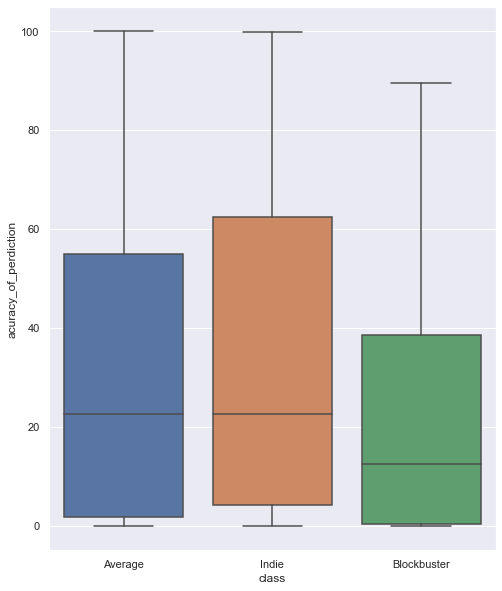

In [24]:
sns.set(rc={'figure.figsize':(8,10)})
_ = sns.boxplot(y='acuracy_of_perdiction',data=result,x='class')

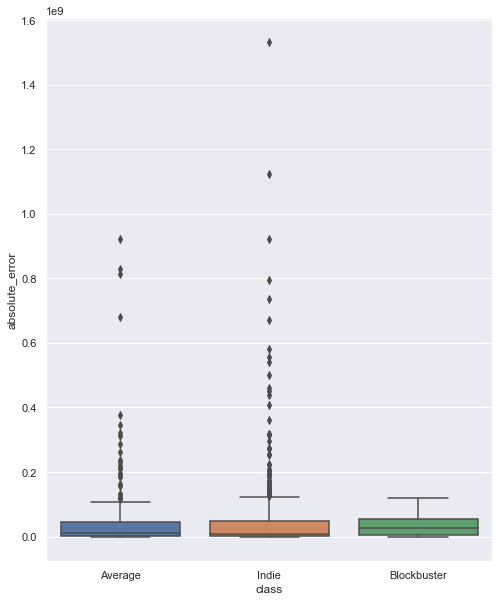

In [25]:
sns.set(rc={'figure.figsize':(8,10)})
_ = sns.boxplot(y='absolute_error',data=result,x='class')

We can see the acuracy for the Blockbuster is worse among the clases and that is mainly because box-office for those film has a very high number, and even if the prediction is in close range of the real value the diffrence still be a high number and that would cause the acuracy percentage drop.
beside that we see what we expect from the R2 score. Acuracy arond 20 to 60 percent with the median around 30 depands on the class.
While the model won't be able to get us a perfect prediction, but we can assume it will classify the film class with high acuracy. 
We can examine that with some real vote data that are more recent and are not in our original dataset.

The absoulate error on the other hand is around 50 to 10 millions for the most cases, which is a good number for the Blockbuster and Average class. Althought there are some outlier in Indie and average class with very high error.

let's start with a big movie in 2021. __Spider-Man : No Way Home.__

In [26]:
spider = pd.DataFrame({     'tom_cri_vote':[93],
                            'tom_cri_num':[385],
                            'tom_aud_vote':[98],
                            'tom_aud_num':[25000],
                            'met_cri_vote':[71],
                            'met_cri_num':[59],
                            'met_aud_vote':[89],
                            'met_aud_num':[2013],
                            'imdb_vote':[87],
                            'imdb_num':[451025],
                            'imdb_us_vote':[87],
                            'imdb_us_num':[34371],
                            'imdb_nus_vote':[84],
                            'imdb_nus_num':[87342],
                            'imdb_fem_vote':[88],
                            'imdb_fem_num':[26676],
                            'imdb_mal_vote':[86],
                            'imdb_mal_num':[162657]
                 })

In [27]:
spider_box_predict = rf_model.predict(spider.iloc[0].array.reshape(1, -1))

In [28]:
spider_box_predict

array([8.58447524e+08])

The model predict that this film box-office will be 850 million dollars based on the vote data that we provide.
The film end up with 1.7 Bilion dollar in box-office. There is a very large error in the model prediction ( around 900 million dollar) but the model succesfuly predict that this film going to be a big Blockbuster with very high box-office gross.

Let's check another promising film in 2021: __Dune__. althoght it is not a Super Hero or a Marvel movie, but with very well-known casts, huge advertisment campain and pick the chrismas time relese, the producer hope to gain a good gross in box-office, number close to a billion.

In [29]:
dune = pd.DataFrame({      'tom_cri_vote':[83],
                            'tom_cri_num':[456],
                            'tom_aud_vote':[90],
                            'tom_aud_num':[5000],
                            'met_cri_vote':[74],
                            'met_cri_num':[67],
                            'met_aud_vote':[80],
                            'met_aud_num':[1371],
                            'imdb_vote':[81],
                            'imdb_num':[478505],
                            'imdb_us_vote':[81],
                            'imdb_us_num':[44798],
                            'imdb_nus_vote':[80],
                            'imdb_nus_num':[142364],
                            'imdb_fem_vote':[81],
                            'imdb_fem_num':[39777],
                            'imdb_mal_vote':[81],
                            'imdb_mal_num':[224114]
                 })

In [30]:
dune_box_predict = rf_model.predict(dune.iloc[0].array.reshape(1, -1))

In [31]:
dune_box_predict

array([6.38620198e+08])

Model predicts 650 million dollar box-office for Dune and in reality it gained 400 millions. This is even a closer prediction and succeful classification of the movie as a Blockbuster. Seems if the box-office is less than a billion we will have a closer prediction.

Now let's check another promising film, it is not a Marvel Super Hero or a Sci-fi movie, but it has a very famouse director, and Al Pacino and Lady Gaga as a cast and an interesting story. __House of Gucci__

In [32]:
house_of_gucci = pd.DataFrame({     'tom_cri_vote':[63],
                                    'tom_cri_num':[335],
                                    'tom_aud_vote':[83],
                                    'tom_aud_num':[2500],
                                    'met_cri_vote':[59],
                                    'met_cri_num':[57],
                                    'met_aud_vote':[80],
                                    'met_aud_num':[857],
                                    'imdb_vote':[68],
                                    'imdb_num':[64497],
                                    'imdb_us_vote':[67],
                                    'imdb_us_num':[6084],
                                    'imdb_nus_vote':[67],
                                    'imdb_nus_num':[20533],
                                    'imdb_fem_vote':[69],
                                    'imdb_fem_num':[8867],
                                    'imdb_mal_vote':[67],
                                    'imdb_mal_num':[27604]
                 })

In [33]:
house_of_gucci_box_predict = rf_model.predict(house_of_gucci.iloc[0].array.reshape(1, -1))

In [34]:
house_of_gucci_box_predict

array([2.70107102e+08])

Model predicts a 270 million dollar box-office for the film which is less than we expect form this cast and director.
In reality it gains only 150 millions dollars, people didn't like it even with the big cast and famous Ridly Scott as a director.

Model classify it sussefuly as an average movie acording to the vote number we used and predict a close box-office for the film.

Now Let's try the Independent film with a low budget that critics loved it. Story about princess diana that seems still is hot a story specially in 2021. __Spencer__



In [35]:
spencer = pd.DataFrame({    'tom_cri_vote':[83],
                            'tom_cri_num':[321],
                            'tom_aud_vote':[52],
                            'tom_aud_num':[500],
                            'met_cri_vote':[76],
                            'met_cri_num':[53],
                            'met_aud_vote':[67],
                            'met_aud_num':[260],
                            'imdb_vote':[68],
                            'imdb_num':[36549],
                            'imdb_us_vote':[69],
                            'imdb_us_num':[4371],
                            'imdb_nus_vote':[67],
                            'imdb_nus_num':[12148],
                            'imdb_fem_vote':[65],
                            'imdb_fem_num':[5724],
                            'imdb_mal_vote':[68],
                            'imdb_mal_num':[15806]
                 })

In [36]:
spencer_box_predict = rf_model.predict(spencer.iloc[0].array.reshape(1, -1))

In [37]:
spencer_box_predict

array([44707359.11635715])

This film gets a high vote from the critics and nominate for oscars season, but it ends up with 20 millions dollars at box-office.

Model perdict 44 millions, very close number and classify correctly as an indie film.

Let's try a more independent film, agained loved by critics at Cann film festival, but this one doesn't even have a hot story or interesting cast.

In [38]:
bergman_island = pd.DataFrame({     'tom_cri_vote':[86],
                                    'tom_cri_num':[118],
                                    'tom_aud_vote':[52],
                                    'tom_aud_num':[50],
                                    'met_cri_vote':[81],
                                    'met_cri_num':[26],
                                    'met_aud_vote':[66],
                                    'met_aud_num':[20],
                                    'imdb_vote':[68],
                                    'imdb_num':[3878],
                                    'imdb_us_vote':[68],
                                    'imdb_us_num':[556],
                                    'imdb_nus_vote':[67],
                                    'imdb_nus_num':[1727],
                                    'imdb_fem_vote':[66],
                                    'imdb_fem_num':[475],
                                    'imdb_mal_vote':[68],
                                    'imdb_mal_num':[2268]
                 })

In [39]:
bergman_island_box_predict = rf_model.predict(bergman_island.iloc[0].array.reshape(1, -1))

In [40]:
bergman_island_box_predict

array([2367437.25487446])

Model predict only 2 million dollars for this film based on the vote data and it actually ends up gain only 700 thousend dollars in real life.
Even if we create a movie classes with smaller margine ( in compare to the original three class that I made), this model would be abale to recognize the movie class with high accuracy, and predict a close number for the box-office.


In [41]:
first_cow = pd.DataFrame({     'tom_cri_vote':[96],
                                    'tom_cri_num':[210],
                                    'tom_aud_vote':[63],
                                    'tom_aud_num':[500],
                                    'met_cri_vote':[89],
                                    'met_cri_num':[44],
                                    'met_aud_vote':[70],
                                    'met_aud_num':[114],
                                    'imdb_vote':[71],
                                    'imdb_num':[16957],
                                    'imdb_us_vote':[71],
                                    'imdb_us_num':[2907],
                                    'imdb_nus_vote':[71],
                                    'imdb_nus_num':[7091],
                                    'imdb_fem_vote':[70],
                                    'imdb_fem_num':[1440],
                                    'imdb_mal_vote':[72],
                                    'imdb_mal_num':[10606]
                 })

In [42]:
first_cow_box_predict = rf_model.predict(first_cow.iloc[0].array.reshape(1, -1))

In [43]:
first_cow_box_predict

array([13941108.95813204])